In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Preprocessing**

Read data and store it in dataframe

In [ ]:
# Generate data paths with labels
data_dir = '/content/drive/MyDrive/Datasets/Multi-class Weather Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

,filepaths,labels
0,/content/drive/MyDrive/Datasets/Multi-class We...,Rain
1,/content/drive/MyDrive/Datasets/Multi-class We...,Rain
2,/content/drive/MyDrive/Datasets/Multi-class We...,Rain
3,/content/drive/MyDrive/Datasets/Multi-class We...,Rain
4,/content/drive/MyDrive/Datasets/Multi-class We...,Rain
...,...,...
1120,/content/drive/MyDrive/Datasets/Multi-class We...,Sunrise
1121,/content/drive/MyDrive/Datasets/Multi-class We...,Sunrise
1122,/content/drive/MyDrive/Datasets/Multi-class We...,Sunrise
1123,/content/drive/MyDrive/Datasets/Multi-class We...,Sunrise


**Split dataframe into train, valid, and test**

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

**Create image data generator**

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 900 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.


**Show sample from train data**

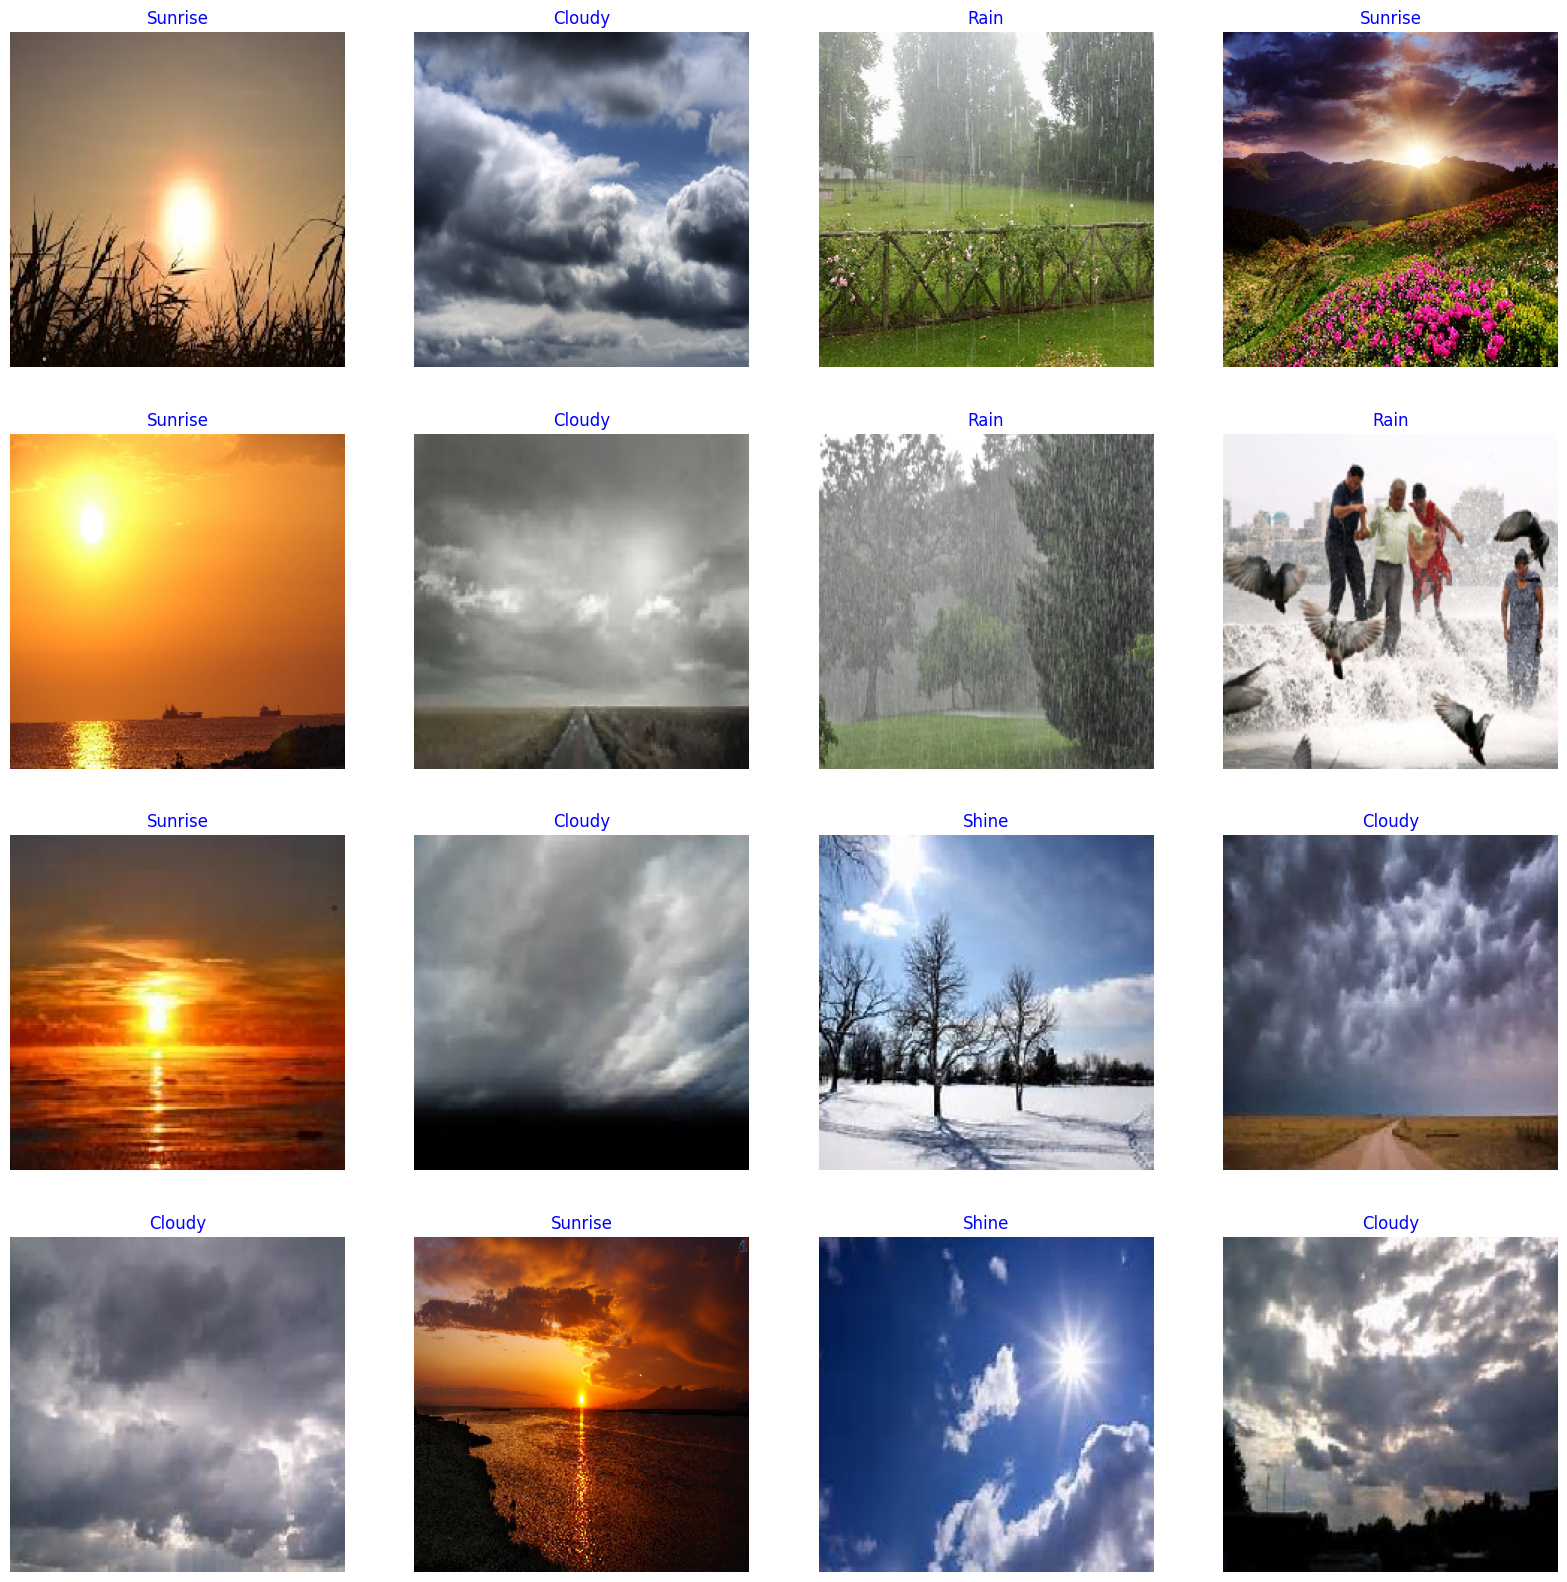

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

**Model Structure**

Generic Model Creation

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet",
                                                               input_shape= img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy',
              metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])

model.summary()

43941136/43941136 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                         

**Train model**

In [ ]:
epochs = 25   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/25
57/57 [==============================] - 494s 8s/step - loss: 8.0529 - accuracy: 0.7789 - precision: 0.8076 - recall: 0.7600 - auc: 0.9424 - val_loss: 7.7641 - val_accuracy: 0.8370 - val_precision: 0.8370 - val_recall: 0.8370 - val_auc: 0.9647
Epoch 2/25
57/57 [==============================] - 16s 275ms/step - loss: 6.7181 - accuracy: 0.9444 - precision: 0.9516 - recall: 0.9389 - auc: 0.9936 - val_loss: 6.3453 - val_accuracy: 0.9704 - val_precision: 0.9704 - val_recall: 0.9704 - val_auc: 0.9986
Epoch 3/25
57/57 [==============================] - 16s 270ms/step - loss: 5.9360 - accuracy: 0.9544 - precision: 0.9617 - recall: 0.9489 - auc: 0.9956 - val_loss: 5.6092 - val_accuracy: 0.9852 - val_precision: 0.9925 - val_recall: 0.9852 - val_auc: 0.9996
Epoch 4/25
57/57 [==============================] - 15s 271ms/step - loss: 5.2893 - accuracy: 0.9678 - precision: 0.9774 - recall: 0.9611 - auc: 0.9974 - val_loss: 5.0337 - val_accuracy: 0.9778 - val_precision: 0.9778 - val_recall:

**Display model performance**

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_perc = history.history['precision']
tr_recall = history.history['recall']
tr_auc = history.history['auc']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_perc = history.history['val_precision']
val_recall = history.history['val_recall']
val_auc = history.history['val_auc']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_perc = np.argmax(val_perc)
perc_highest = val_perc[index_perc]

index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

index_auc = np.argmax(val_auc)
auc_highest = val_auc[index_auc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
perc_label = f'best epoch= {str(index_perc + 1)}'
recall_label = f'best epoch= {str(index_recall + 1)}'
auc_label = f'best epoch= {str(index_auc + 1)}'

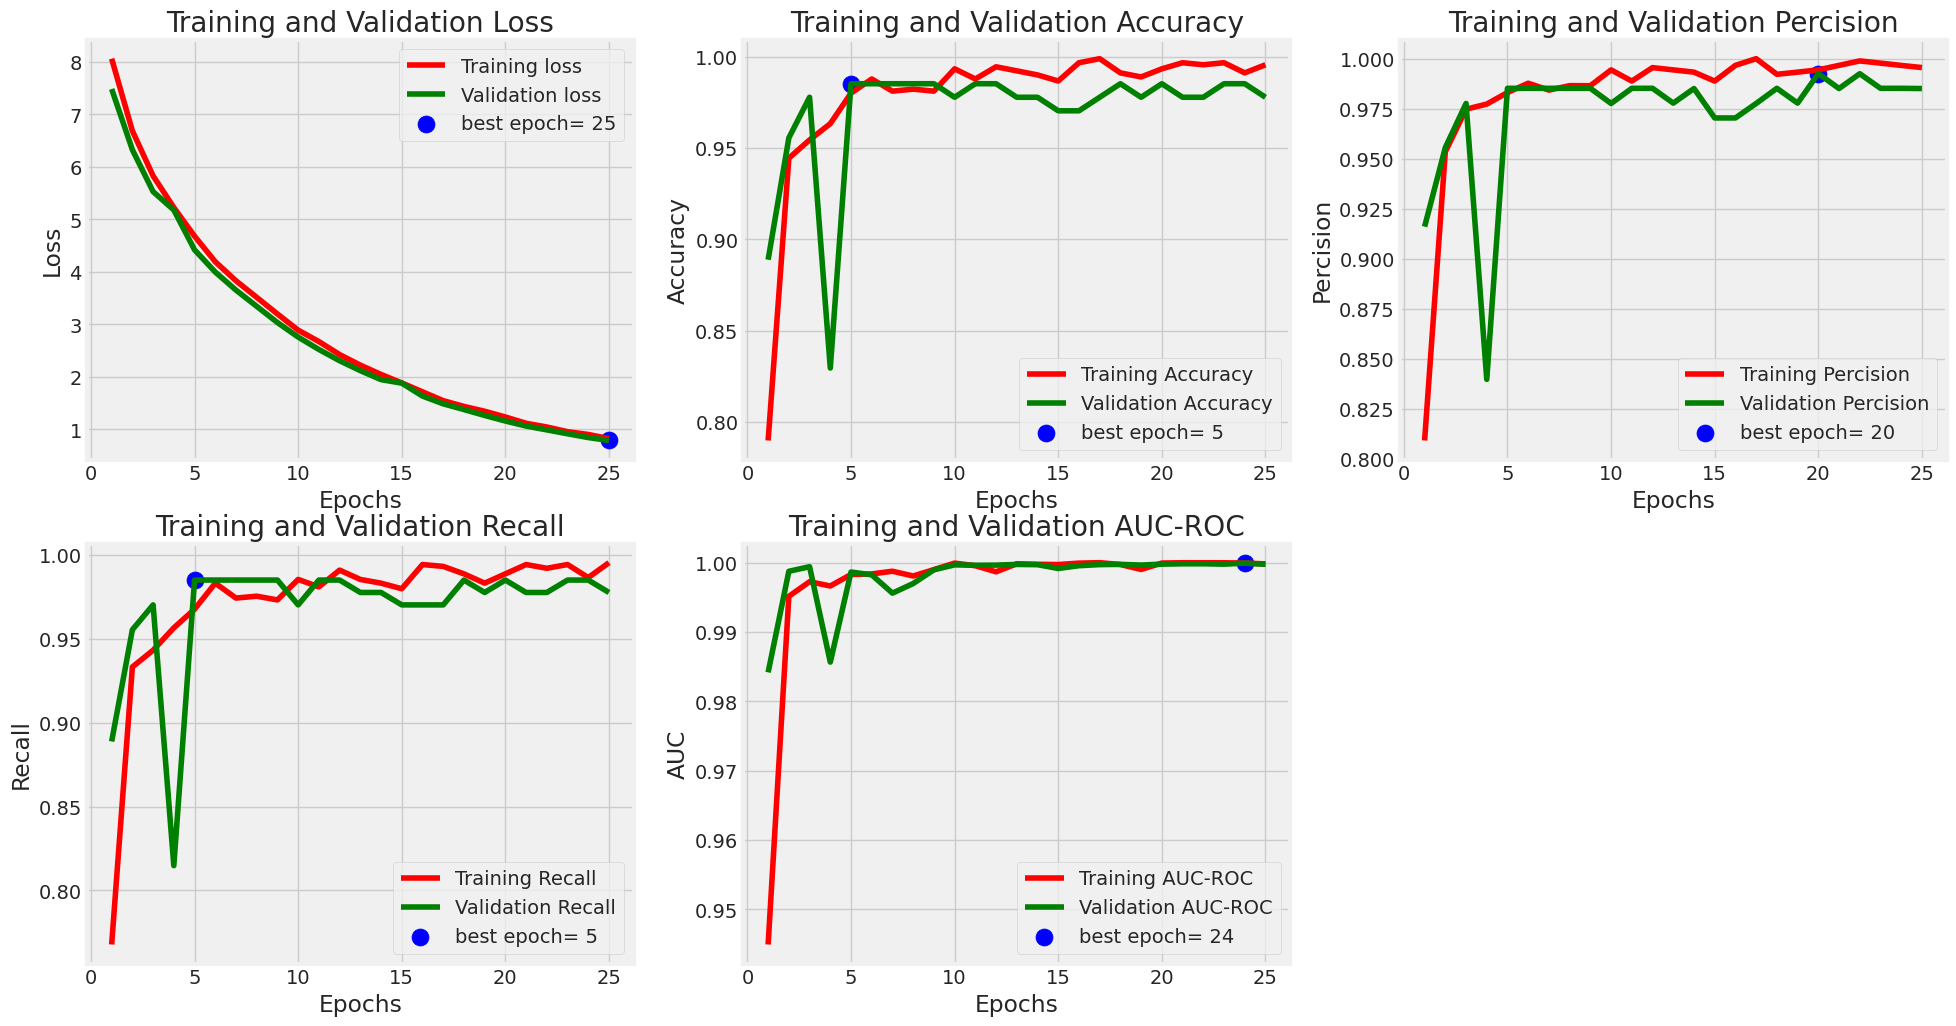

In [ ]:
# Plot training history
plt.figure(figsize= (24, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
\
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(Epochs, tr_perc, 'r', label= 'Training Percision')
plt.plot(Epochs, val_perc, 'g', label= 'Validation Percision')
plt.scatter(index_perc + 1 , perc_highest, s= 150, c= 'blue', label= perc_label)
plt.title('Training and Validation Percision')
plt.xlabel('Epochs')
plt.ylabel('Percision')
plt.legend()
plt.subplot(2, 3, 4)
plt.plot(Epochs, tr_recall, 'r', label= 'Training Recall')
plt.plot(Epochs, val_recall, 'g', label= 'Validation Recall')
plt.scatter(index_recall + 1 , recall_highest, s= 150, c= 'blue', label= recall_label)
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(Epochs, tr_auc, 'r', label= 'Training AUC-ROC')
plt.plot(Epochs, val_auc, 'g', label= 'Validation AUC-ROC')
plt.scatter(index_auc + 1 , auc_highest, s= 150, c= 'blue', label= auc_label)
plt.title('Training and Validation AUC-ROC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

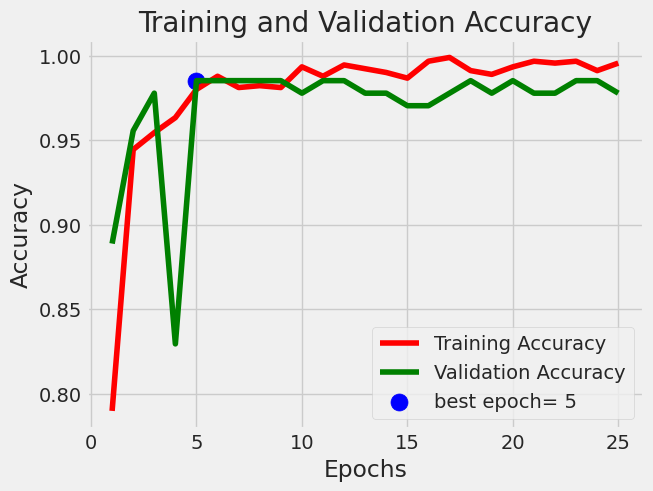

In [ ]:
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

**Evaluate model**

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 4s 4s/step - loss: 0.7604 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Train Loss:  0.7468159794807434
Train Accuracy:  1.0
--------------------
Validation Loss:  0.8490257263183594
Validation Accuracy:  0.9375
--------------------
Test Loss:  0.7603764533996582
Test Accuracy:  1.0


**Get Predictions**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

**Confusion Matrics and Classification Report**

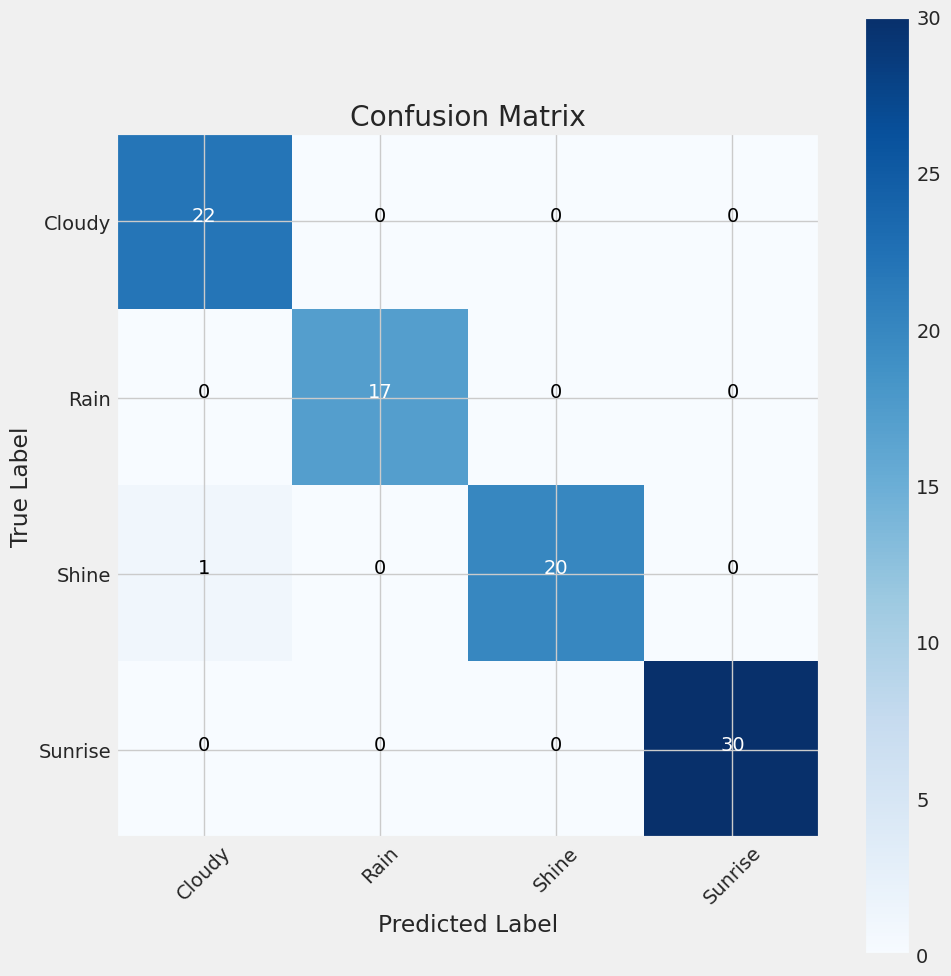

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      Cloudy       0.96      1.00      0.98        22
        Rain       1.00      1.00      1.00        17
       Shine       1.00      0.95      0.98        21
     Sunrise       1.00      1.00      1.00        30

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



**Save model**

In [ ]:
#Save the model
model.save( 'Weather Model.h5')

**Prediction using loaded_model**

In [ ]:
loaded_model = tf.keras.models.load_model('/content/Weather Model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/drive/MyDrive/Datasets/Multi-class Weather Dataset/Shine/shine101.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Cloudy', 'Rain','Shine','Sunrise']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 3s 3s/step
Shine
